In [60]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pylab
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [61]:
debug = False

In [62]:
iris = datasets.load_iris()
x_vals = np.array([x[0:4] for x in iris.data])
y_vals = np.array([y for y in iris.target])

# Transform to Onehot
y_vals = np.array(y_vals).reshape(1, -1).transpose()
encoder = OneHotEncoder(n_values=max(y_vals)+1)
y_vals = encoder.fit_transform(y_vals).toarray()

In [63]:
x_train, x_test, d_train, d_test = train_test_split(x_vals, y_vals, test_size=0.2, random_state=None,)
train_size = len(x_train)

print("データ読み込み完了")
if debug:
    print("x_train", x_train.shape)
    print("x_test", x_test.shape)
    print("d_train", d_train.shape)
    print("d_test", d_test.shape)

データ読み込み完了


In [64]:
# 重み初期値補正係数
wieght_init = 0.01
#入力層サイズ
input_layer_size = 4
#中間層サイズ
hidden_layer1_size = 64
hidden_layer2_size = 128
hidden_layer3_size = 128

num_hidden_layers = 3
#出力層サイズ
output_layer_size = 3
# 繰り返し数
iters_num = 3000
# ミニバッチサイズ
batch_size = 40
# 学習率
learning_rate=0.001
# 描写頻度
plot_interval= 10

# Adam parameters
beta1 = 0.9
beta2 = 0.999

# 正則化強度設定 ======================================
weight_decay_lambda = 0.01
# =================================================

# ドリップアウト
dropout_ratio = 0.4

In [65]:
# ReLU関数
def relu(x):
    return np.maximum(0, x)
# 出力層の活性化関数
# ソフトマックス関数
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

# ReLU関数の導関数
def d_relu(x):
    return np.where( x > 0, 1, 0)
# ソフトマックスとクロスエントロピーの複合導関数
def d_softmax_with_loss(d, y):
    batch_size = d.shape[0]
    if d.size == y.size: # 教師データがone-hot-vectorの場合
        dx = (y - d) / batch_size
    else:
        dx = y.copy()
        dx[np.arange(batch_size), d] -= 1
        dx = dx / batch_size
    return dx

def cross_entropy_error(d, y):
    y_max = np.argmax(y, axis=1)
    d_max = np.argmax(d, axis=1)

    batch_size = y_max.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), d_max] + 1e-7)) / batch_size

def accuracy(d, y):
    y_max = np.argmax(y, axis=1)
    d_max = np.argmax(d, axis=1)
    
    batch_size = float(y_max.shape[0])
    return np.sum(y_max == d_max) / batch_size

In [66]:
# 初期設定
def init_network():
    network = {} 
    # Heの初期値    
    network['W1'] = np.random.randn(input_layer_size, hidden_layer1_size) / np.sqrt(input_layer_size) * np.sqrt(2)
    network['W2'] = np.random.randn(hidden_layer1_size, hidden_layer2_size) / np.sqrt(hidden_layer1_size) * np.sqrt(2)
    network['W3'] = np.random.randn(hidden_layer2_size, hidden_layer3_size) / np.sqrt(hidden_layer2_size) * np.sqrt(2)
    network['W4'] = np.random.randn(hidden_layer3_size, output_layer_size) / np.sqrt(hidden_layer3_size) * np.sqrt(2)

    network['b1'] = np.zeros(hidden_layer1_size)
    network['b2'] = np.zeros(hidden_layer2_size)
    network['b3'] = np.zeros(hidden_layer3_size)
    network['b4'] = np.zeros(output_layer_size)

    return network

In [67]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

In [68]:
# 順伝播
def forward(network, x, train_flg):
    W = {}
    dropout = {}
    W1, W2, W3, W4 = network['W1'], network['W2'], network['W3'], network['W4']
    b1, b2, b3, b4  = network['b1'], network['b2'], network['b3'], network['b4']

    for idx in range(num_hidden_layers):
        dropout['u' + str(idx+1)] = Dropout(dropout_ratio)
        
    # 1st Layer
    u1 = np.dot(x, W1) + b1
    u1 = dropout['u1'].forward(u1, train_flg=train_flg)
    z1 = relu(u1)
    # 2nd Layer
    u2 = np.dot(z1, W2) + b2
    u2 = dropout['u2'].forward(u2, train_flg=train_flg)
    z2 = relu(u2)
    #3rd Layer
    u3 = np.dot(z2, W3) + b3
    u3 = dropout['u3'].forward(u3, train_flg=train_flg)
    z3 = relu(u3)
    #4th Layer
    u4 = np.dot(z3, W4) + b4
    y  = softmax(u4)

    return z1, z2, z3, y, dropout

In [69]:
# 誤差逆伝播
def backward(x, d, z1, z2, z3, y, dropout):
    grad = {}
    
    W1, W2, W3, W4 = network['W1'], network['W2'], network['W3'], network['W4']
    b1, b2, b3, b4 = network['b1'], network['b2'], network['b3'], network['b4']
    # 出力層でのデルタ
    delta4 = d_softmax_with_loss(d, y)
    grad['b4'] = np.sum(delta4, axis=0)
    grad['W4'] = np.dot(z3.T, delta4) + weight_decay_lambda * W4

    delta3 = np.dot(delta4, W4.T) * d_relu(z3)
    delta3 = dropout['u3'].backward(delta3)
    grad['b3'] = np.sum(delta3, axis=0)
    grad['W3'] = np.dot(z2.T, delta3) + weight_decay_lambda * W3
    # 2層でのデルタ       
    delta2 = np.dot(delta3, W3.T) * d_relu(z2)
    delta2 = dropout['u2'].backward(delta2)
    grad['b2'] = np.sum(delta2, axis=0)
    grad['W2'] = np.dot(z1.T, delta2) + weight_decay_lambda * W2
    # 1層でのデルタ       
    delta1 = np.dot(delta2, W2.T) * d_relu(z1)
    delta1 = dropout['u1'].backward(delta1)
    grad['b1'] = np.sum(delta1, axis=0)
    grad['W1'] = np.dot(x.T, delta1) + weight_decay_lambda * W1

    return grad

In [70]:
# パラメータの初期化
network = init_network()

losses = []
losses_test = []
accuracies = []
accuracies_test = []
    

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]
    #d_batch = d_batch[:, np.newaxis]
    
    z1, z2, z3, y, dropout = forward(network, x_batch, train_flg=True)
    grad = backward(x_batch, d_batch, z1, z2, z3, y, dropout)
    
    #for Test
    z1_test, z2_test, z3_test, y_test, dropout = forward(network, x_test, train_flg=False)
        
    # Adam ====================================================
    if i == 0:
        m = {}
        v = {}
    
    learning_rate_t  = learning_rate * np.sqrt(1.0 - beta2 ** (i + 1)) / (1.0 - beta1 ** (i + 1))
    
    for key in ('W1', 'W2', 'W3','W4', 'b1', 'b2', 'b3', 'b4'):

        if i == 0:
            m[key] = np.zeros_like(network[key])
            v[key] = np.zeros_like(network[key])
            
        m[key] += (1 - beta1) * (grad[key] - m[key])
        v[key] += (1 - beta2) * (grad[key] ** 2 - v[key])            

        network[key] -= learning_rate_t * m[key] / (np.sqrt(v[key]) + 1e-7)
        
            
    # =========================================================

    #     print('loss',functions.least_square(d_batch, y))
    if (i + 1) % plot_interval == 0:
        loss = cross_entropy_error(d_batch, y)
        losses.append(loss)
        acc = accuracy(d_batch, y)
        accuracies.append(acc)
        
        loss_test = cross_entropy_error(d_test, y_test)
        losses_test.append(loss_test)
        acc_test = accuracy(d_test, y_test)
        accuracies_test.append(acc_test)
        #print(loss_train)
        #print('Generation: ' + str(i+1) + '. 誤差 = ' + str(loss))
        print('                : ' + str(i+1) + '. 誤差(テスト) = ' + str(loss_test))
        print('                : ' + str(i+1) + '. 精度(テスト) = ' + str(acc_test))
                

                : 10. 誤差(テスト) = 1.350602063215346
                : 10. 精度(テスト) = 0.23333333333333334
                : 20. 誤差(テスト) = 1.0806433937284503
                : 20. 精度(テスト) = 0.23333333333333334
                : 30. 誤差(テスト) = 0.8518228448207481
                : 30. 精度(テスト) = 0.8333333333333334
                : 40. 誤差(テスト) = 0.9307597132214502
                : 40. 精度(テスト) = 0.5666666666666667
                : 50. 誤差(テスト) = 0.988244756126764
                : 50. 精度(テスト) = 0.5666666666666667
                : 60. 誤差(テスト) = 0.8719042513533451
                : 60. 精度(テスト) = 0.5666666666666667
                : 70. 誤差(テスト) = 0.7527721910426819
                : 70. 精度(テスト) = 0.5666666666666667
                : 80. 誤差(テスト) = 0.7170171365489149
                : 80. 精度(テスト) = 0.5666666666666667
                : 90. 誤差(テスト) = 0.7340963212002545
                : 90. 精度(テスト) = 0.5666666666666667
                : 100. 誤差(テスト) = 0.7110466316167179
                : 100. 精度(テスト)

                : 840. 誤差(テスト) = 0.14234424765903744
                : 840. 精度(テスト) = 1.0
                : 850. 誤差(テスト) = 0.14378634850563546
                : 850. 精度(テスト) = 1.0
                : 860. 誤差(テスト) = 0.13818927480650378
                : 860. 精度(テスト) = 1.0
                : 870. 誤差(テスト) = 0.1466408976305287
                : 870. 精度(テスト) = 0.9666666666666667
                : 880. 誤差(テスト) = 0.14005669703388132
                : 880. 精度(テスト) = 0.9666666666666667
                : 890. 誤差(テスト) = 0.12693473503983507
                : 890. 精度(テスト) = 1.0
                : 900. 誤差(テスト) = 0.14211641478588907
                : 900. 精度(テスト) = 0.9666666666666667
                : 910. 誤差(テスト) = 0.11675694432069732
                : 910. 精度(テスト) = 1.0
                : 920. 誤差(テスト) = 0.11609360384440204
                : 920. 精度(テスト) = 1.0
                : 930. 誤差(テスト) = 0.13804225919435076
                : 930. 精度(テスト) = 0.9666666666666667
                : 940. 誤差(テスト) = 0.125901

                : 1730. 誤差(テスト) = 0.05251161367551086
                : 1730. 精度(テスト) = 1.0
                : 1740. 誤差(テスト) = 0.05603356356304497
                : 1740. 精度(テスト) = 1.0
                : 1750. 誤差(テスト) = 0.05252114283857728
                : 1750. 精度(テスト) = 1.0
                : 1760. 誤差(テスト) = 0.05224117691003141
                : 1760. 精度(テスト) = 1.0
                : 1770. 誤差(テスト) = 0.05135671891375445
                : 1770. 精度(テスト) = 1.0
                : 1780. 誤差(テスト) = 0.052052043023515265
                : 1780. 精度(テスト) = 1.0
                : 1790. 誤差(テスト) = 0.048763584171405853
                : 1790. 精度(テスト) = 1.0
                : 1800. 誤差(テスト) = 0.05001707304514685
                : 1800. 精度(テスト) = 1.0
                : 1810. 誤差(テスト) = 0.05127668784788097
                : 1810. 精度(テスト) = 1.0
                : 1820. 誤差(テスト) = 0.05396456186267976
                : 1820. 精度(テスト) = 1.0
                : 1830. 誤差(テスト) = 0.04867283706301069
                : 1830. 

                : 2610. 誤差(テスト) = 0.04607729500702625
                : 2610. 精度(テスト) = 1.0
                : 2620. 誤差(テスト) = 0.054374410643274314
                : 2620. 精度(テスト) = 1.0
                : 2630. 誤差(テスト) = 0.05424042786491838
                : 2630. 精度(テスト) = 1.0
                : 2640. 誤差(テスト) = 0.053589971167995486
                : 2640. 精度(テスト) = 1.0
                : 2650. 誤差(テスト) = 0.05282470498092454
                : 2650. 精度(テスト) = 1.0
                : 2660. 誤差(テスト) = 0.05187514862896283
                : 2660. 精度(テスト) = 1.0
                : 2670. 誤差(テスト) = 0.05356033254298077
                : 2670. 精度(テスト) = 1.0
                : 2680. 誤差(テスト) = 0.052357546770522616
                : 2680. 精度(テスト) = 1.0
                : 2690. 誤差(テスト) = 0.050559876468646014
                : 2690. 精度(テスト) = 1.0
                : 2700. 誤差(テスト) = 0.04788939580199482
                : 2700. 精度(テスト) = 1.0
                : 2710. 誤差(テスト) = 0.047857637772367505
                : 271

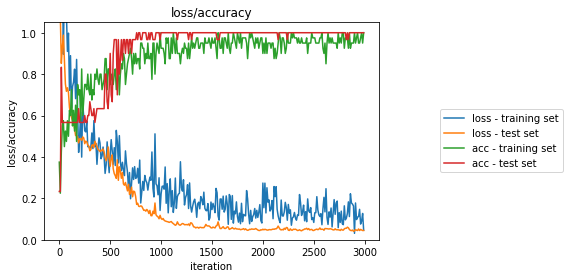

In [71]:
lists = range(0, iters_num, plot_interval)
plt.plot(lists, losses, label="loss - training set")
plt.plot(lists, losses_test,  label="loss - test set")
plt.plot(lists, accuracies, label="acc - training set")
plt.plot(lists, accuracies_test, label="acc - test set")
plt.title("loss/accuracy")
plt.xlabel("iteration")
plt.ylabel("loss/accuracy")
plt.ylim(0, 1.05)
# グラフの表示
plt.legend(loc='best',
           bbox_to_anchor=(1.05, 0.5, 0.5, .100), 
           borderaxespad=0.,)
plt.savefig("output.jpg", bbox_inches='tight')
plt.show()